In [2]:
# base imports
import numpy as np
import pandas as pd
import seaborn as sns

**Data Loading**

In [3]:
all_filled_link = 'https://raw.githubusercontent.com/cgccomeau/Gini-In-A-Bottle/master/dataCleaning/FINALnoFeatInput.csv' #github url of data
all_filled = pd.read_csv(all_filled_link) #load data into pandas dataframe
all_filled #printout


,Unnamed: 0,CountryName,Year,GiniCoff,IncomePerPeerson,InvestmentShareOfGDP,TaxShareOfGDP,"Estimates, 1950 - 2020: Annually interpolated demographic indicators - Total fertility (live births per woman)",Deaths - Self-harm - Sex: Both - Age: All Ages (Percent),Life satisfaction in Cantril Ladder (World Happiness Report 2019),"Agriculture, value added per worker (constant 2010 US$)",Life expectancy,"Unemployment, total (% of total labor force) (modeled ILO estimate)","Real GDP per capita in 2011US$, multiple benchmarks (Maddison Project Database (2018))",Population density (people per sq. km of land area)
0,0,Algeria,2010,28.5,12900,41.4,34.4,2.860,1.100892,5.463567,8234.969797,74.938,9.960,12510.0,15.164391
1,1,Algeria,2011,28.2,13000,38.1,37.2,2.909,1.094819,5.317194,9444.286162,75.199,9.960,13204.0,15.459100
2,2,Benin,2006,40.2,1750,19.0,14.2,5.576,0.648848,3.329802,938.010492,57.817,0.922,1821.0,72.870663
3,3,Benin,2008,41.3,1840,20.4,16.1,5.469,0.669312,3.667140,981.295518,58.654,1.025,1897.0,77.127669
4,4,Benin,2011,43.1,1820,24.1,14.8,5.305,0.726954,3.870280,1009.683580,59.590,2.650,1836.0,83.902111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,920,New Zealand,2012,33.5,33300,20.9,26.8,2.060,1.777760,7.249630,99190.940341,81.233,6.410,31720.0,16.741104
921,921,New Zealand,2013,34.0,33900,22.0,26.6,2.028,1.731599,7.280152,100493.285577,81.402,5.760,32708.0,16.870229
922,922,New Zealand,2014,34.0,34600,22.9,26.8,1.995,1.671679,7.305892,105875.690663,81.561,5.380,33091.0,17.126961
923,923,New Zealand,2015,34.5,35200,23.4,27.4,1.965,1.653716,7.418121,110619.851350,81.713,5.370,33445.0,17.453572


**Before PCA - test/train split by year**

In [ ]:
# test/train splits
from sklearn.model_selection import train_test_split

# for all filled case, split equally by year
all_filled_df = all_filled.iloc[:, [False, True, True, True, True, True, True, True, True, True, True, True, True, True, True]]
grouped_all_filled = all_filled_df.groupby(all_filled_df.Year)
# array of pandas dataframes by year with all countries - index 0 is 2006, 1 is 2007, etc.
dfarr_all_filled = [grouped_all_filled.get_group(2006 + i) for i in range(11)] 
# array of feature dataframes, indexed same as dfarr_all_filled
Xarr_all_filled = [df.iloc[:,[False, False, False, True, True, True, True, True, True, True, True, True, True, True]] for df in dfarr_all_filled]
# array of gini dataframes, indexed same as dfarr_all_filled
Yarr_all_filled = [df.iloc[:,[False, False, True, False, False, False, False, False, False, False, False, False, False, False]] for df in dfarr_all_filled]

X_train_all_filled, Y_train_all_filled, X_test_all_filled, Y_test_all_filled = [], [], [], []
for i in range(11):
  X_train, X_test, y_train, y_test = train_test_split(Xarr_all_filled[i], Yarr_all_filled[i], test_size = 0.15, random_state = 35)
  X_train_all_filled.append(X_train)
  X_test_all_filled.append(X_test)
  Y_train_all_filled.append(y_train)
  Y_test_all_filled.append(y_test)

#use these variables in model for all filled case
X_train_all_filled = pd.concat(X_train_all_filled)
Y_train_all_filled = pd.concat(Y_train_all_filled)
X_test_all_filled = pd.concat(X_test_all_filled)
Y_test_all_filled = pd.concat(Y_test_all_filled)
train_all_filled = pd.concat([X_train_all_filled, Y_train_all_filled], axis = 1)
test_all_filled = pd.concat([X_test_all_filled, Y_test_all_filled], axis = 1)
print(all_filled_df)

#print(X_train_all_filled)
#print(Y_train_all_filled)
#print(X_test_all_filled)
#print(Y_test_all_filled)
#print(train_all_filled)
#print(test_all_filled)

     CountryName  ...  Population density (people per sq. km of land area)
0        Algeria  ...                                          15.164391  
1        Algeria  ...                                          15.459100  
2          Benin  ...                                          72.870663  
3          Benin  ...                                          77.127669  
4          Benin  ...                                          83.902111  
..           ...  ...                                                ...  
920  New Zealand  ...                                          16.741104  
921  New Zealand  ...                                          16.870229  
922  New Zealand  ...                                          17.126961  
923  New Zealand  ...                                          17.453572  
924  New Zealand  ...                                          17.823858  

[925 rows x 14 columns]


**Data Plotting -- all 11 features**

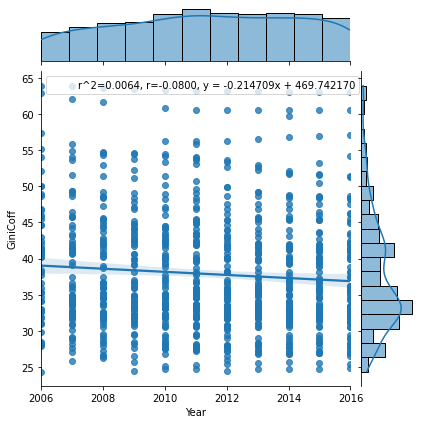

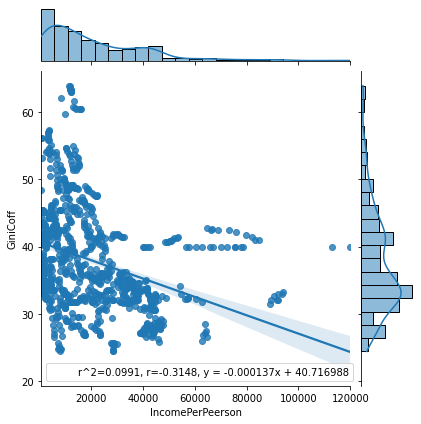

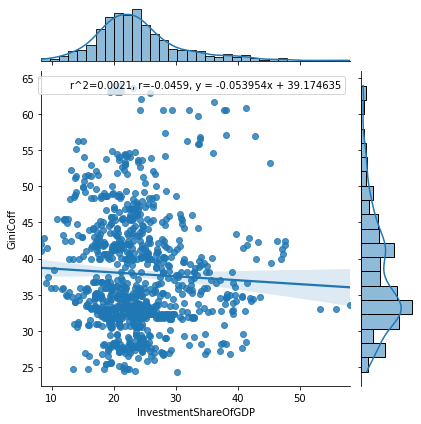

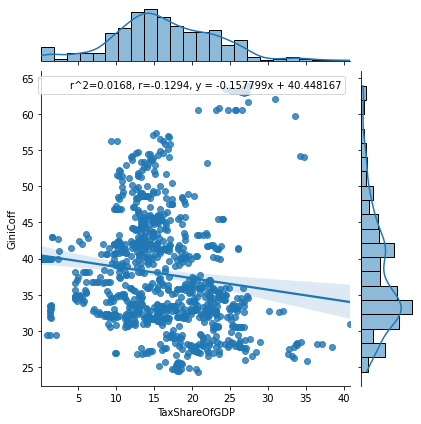

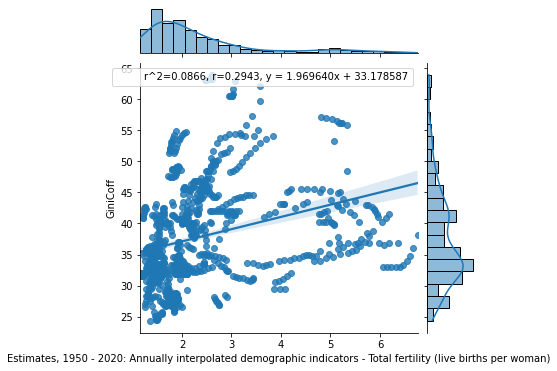

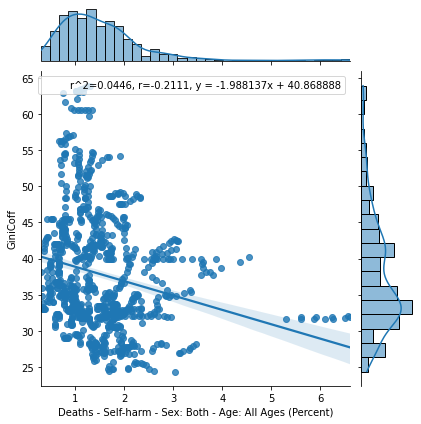

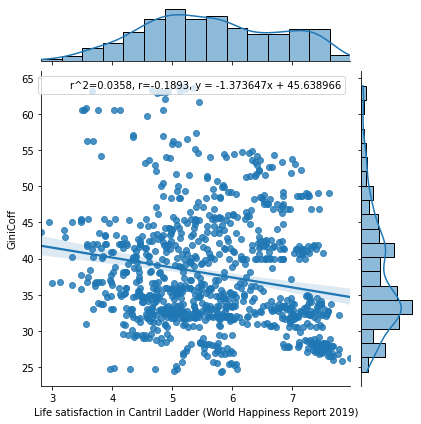

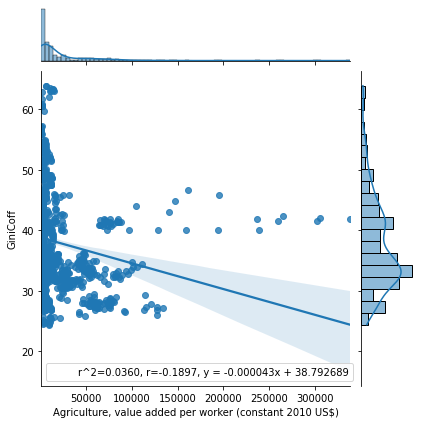

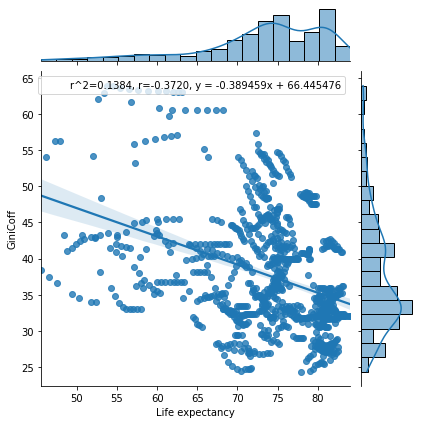

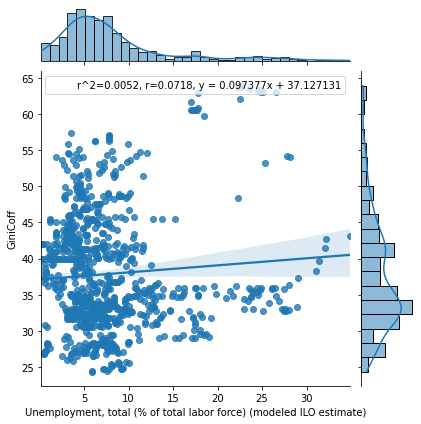

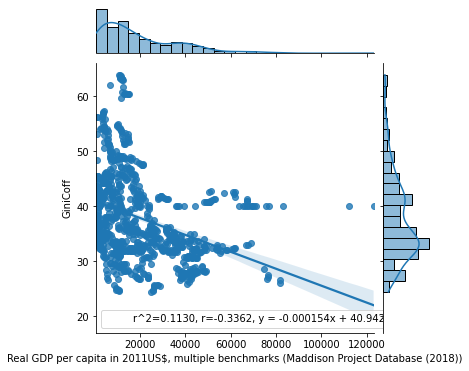

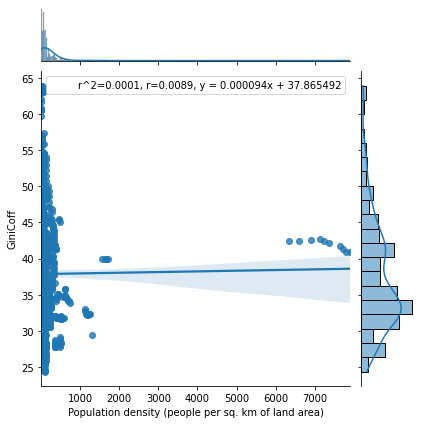

In [ ]:
#data plotting
import scipy.stats as stats

for col in all_filled_df.columns:
  if col != "CountryName" and col != "GiniCoff":
    #graph = sns.lmplot(x = col, y = 'GiniCoff', data=all_filled_df, fit_reg=True)
    slope, intercept, r, _, _ = stats.linregress(all_filled_df[col], all_filled_df['GiniCoff'])
    rsquared = r ** 2
    graph = sns.jointplot(x = col, y = 'GiniCoff', data = all_filled_df, kind = "reg")
    phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
    graph.ax_joint.legend([phantom],['r^2={:.4f}, r={:.4f}, y = {:f}x + {:f}'.format(rsquared, r, slope, intercept)])
a = all_filled_df.corr()

**Linear Regression before PCA**

In [ ]:
# linear regression - Charlie
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# training
reg = LinearRegression().fit(X_train_all_filled, Y_train_all_filled)
gini_predict = reg.predict(X_test_all_filled)

# results
feature_to_coef = {X_train_all_filled.columns[i]: reg.coef_[0][i] for i in range(len(reg.coef_[0]))}
print("Coefficients of best fit line: ")
for key, value in feature_to_coef.items():
  print("{:>110}: {:>.9}".format(key, value))
print("{:>110}: {:>.9}".format("Intercept", reg.intercept_[0]))
print("R^2 value of training: ", reg.score(X_train_all_filled, Y_train_all_filled))
print("R^2 value of prediction: ", r2_score(Y_test_all_filled, gini_predict)) # lol oof

Coefficients of best fit line: 
                                                                                              IncomePerPeerson: 9.98163486e-05
                                                                                          InvestmentShareOfGDP: -0.0339518165
                                                                                                 TaxShareOfGDP: -0.125068731
Estimates, 1950 - 2020: Annually interpolated demographic indicators - Total fertility (live births per woman): -0.338638675
                                                      Deaths - Self-harm - Sex: Both - Age: All Ages (Percent): -0.578412932
                                             Life satisfaction in Cantril Ladder (World Happiness Report 2019): 3.13244401
                                                       Agriculture, value added per worker (constant 2010 US$): -8.88316892e-06
                                                                                         

**PCA**

In [4]:
#svdImpute on wBlankPupilMultiYearData
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_data = all_filled.iloc[:, [False, False, False, False, True, True, True, True, True, True, True, True, True, True, True]]
pca_data

,IncomePerPeerson,InvestmentShareOfGDP,TaxShareOfGDP,"Estimates, 1950 - 2020: Annually interpolated demographic indicators - Total fertility (live births per woman)",Deaths - Self-harm - Sex: Both - Age: All Ages (Percent),Life satisfaction in Cantril Ladder (World Happiness Report 2019),"Agriculture, value added per worker (constant 2010 US$)",Life expectancy,"Unemployment, total (% of total labor force) (modeled ILO estimate)","Real GDP per capita in 2011US$, multiple benchmarks (Maddison Project Database (2018))",Population density (people per sq. km of land area)
0,12900,41.4,34.4,2.860,1.100892,5.463567,8234.969797,74.938,9.960,12510.0,15.164391
1,13000,38.1,37.2,2.909,1.094819,5.317194,9444.286162,75.199,9.960,13204.0,15.459100
2,1750,19.0,14.2,5.576,0.648848,3.329802,938.010492,57.817,0.922,1821.0,72.870663
3,1840,20.4,16.1,5.469,0.669312,3.667140,981.295518,58.654,1.025,1897.0,77.127669
4,1820,24.1,14.8,5.305,0.726954,3.870280,1009.683580,59.590,2.650,1836.0,83.902111
...,...,...,...,...,...,...,...,...,...,...,...
920,33300,20.9,26.8,2.060,1.777760,7.249630,99190.940341,81.233,6.410,31720.0,16.741104
921,33900,22.0,26.6,2.028,1.731599,7.280152,100493.285577,81.402,5.760,32708.0,16.870229
922,34600,22.9,26.8,1.995,1.671679,7.305892,105875.690663,81.561,5.380,33091.0,17.126961
923,35200,23.4,27.4,1.965,1.653716,7.418121,110619.851350,81.713,5.370,33445.0,17.453572


In [ ]:
len(pca_data.columns) #original number of dimenions is 11

11

In [5]:
pca = PCA()
pca.fit(pca_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[1.52783992e+09 4.06890770e+08 6.58883781e+06 4.77037596e+05
 5.03642509e+01 4.70421213e+01 3.00557230e+01 2.55392464e+01
 6.42976111e-01 3.86235538e-01 3.73583233e-01]
[0.78681764 0.99636109 0.99975425 0.99999992 0.99999995 0.99999997
 0.99999999 1.         1.         1.         1.        ]


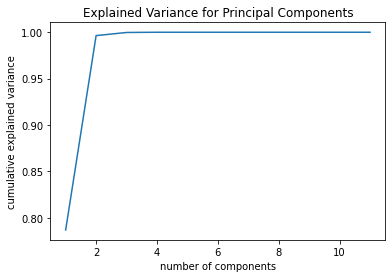

In [6]:
print(pca.explained_variance_)
plt.plot(np.arange(1, 12), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance for Principal Components')
# print(pca.components_)

print((np.cumsum(pca.explained_variance_ratio_)))

original shape:    (925, 11)
transformed shape: (925, 2)


Text(0.5, 1.0, 'Data projected onto first two Principal Axes')

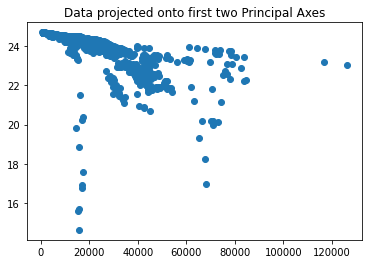

In [7]:
pca2 = PCA(2)
pca2.fit(pca_data)
data_post_pca = pca2.transform(pca_data)
print("original shape:   ", pca_data.shape)
print("transformed shape:", data_post_pca.shape)
data_post_pca = pca2.inverse_transform(data_post_pca)

plt.scatter(data_post_pca[:, 0], data_post_pca[:, 1])
plt.title('Data projected onto first two Principal Axes')
# plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)

###Feature Importance

In [17]:
print(abs( pca.components_[0] ))

[3.28306710e-01 2.98038283e-05 3.59397685e-05 1.02538007e-05
 4.31002821e-06 1.86735995e-05 8.86873863e-01 1.06352269e-04
 8.93479727e-06 3.25067407e-01 7.88936653e-04]


We see that features 1, 7, and 10 are the most important. 

**Clustering**

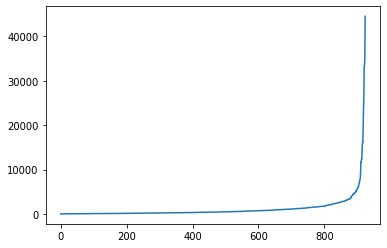

In [8]:
from sklearn import mixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

#Determine optimal value of epsilon for DBSCAN --> looks like 5000
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_post_pca)
distances, indices = nbrs.kneighbors(data_post_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


Estimated number of clusters: 15
Estimated number of noise points: 41
Silhouette Coefficient: 0.302


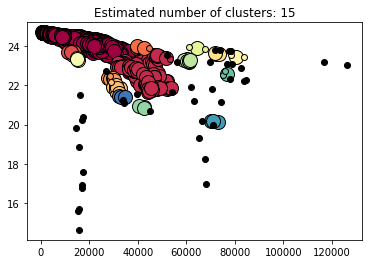

In [9]:

#DBSCAN
db = DBSCAN(eps=5000, min_samples=3).fit(data_post_pca)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data_post_pca, labels))

# #############################################################################
# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_post_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data_post_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [16]:
clusters = pca_data = all_filled.iloc[:, [False, True, False, False, False, False, False, False, False, False, False, False, False, False, False]]
clusters['cluster'] = labels
# clusters

clusters = clusters.drop_duplicates()

clusters.query('cluster == 1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CountryName,cluster
161,Canada,1
291,United States,1
579,Austria,1
599,Belgium,1
641,Denmark,1
661,Finland,1
670,France,1
680,Germany,1
714,Ireland,1
723,Italy,1


Neural Network - Yeojin

In [ ]:
import numpy as np
import pandas as pd
import time
import gc
import random
import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Get x_data and y_data

In [ ]:
y_data = all_filled['GiniCoff']
x_data = all_filled[['IncomePerPeerson', 'InvestmentShareOfGDP', 'TaxShareOfGDP', 'Estimates, 1950 - 2020: Annually interpolated demographic indicators - Total fertility (live births per woman)', 
                  'Deaths - Self-harm - Sex: Both - Age: All Ages (Percent)', 'Life satisfaction in Cantril Ladder (World Happiness Report 2019)', 
                  'Agriculture, value added per worker (constant 2010 US$)', 'Life expectancy', 'Unemployment, total (% of total labor force) (modeled ILO estimate)',
                  'Real GDP per capita in 2011US$, multiple benchmarks (Maddison Project Database (2018))', 'Population density (people per sq. km of land area)']]


Parameter tuning

In [ ]:
alpha_list = [0.0001, 0.001, 0.01]
activation_list = ["identity", "logistic", "tanh", "relu"]
solver = ['lbfgs', 'sgd']
hidden_layers = [1, 2, 3]
learning_rates = ["constant", "invscaling", "adaptive"]

#x_data, y_data = dataAllocation("Option1_data.csv")

result = []
i=0
for alpha in alpha_list:
    for activation in activation_list:
        for layer in hidden_layers:
            for rate in learning_rates:
                test_accuracies = []
                mae_list = []
                mse_list = []
                for i in range(1, 5):
                    i = i+1
                    #print(i)
                    # split the dataset into train and test
                    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
                    
                    # scale x_train
                    scaler = StandardScaler()
                    scaler.fit(X_train_all_filled)
                    X_train_all_filled = scaler.transform(X_train_all_filled)
                    X_test_all_filled = scaler.transform(X_test_all_filled)
                    
                    # run MLPRegressor using params
                    regr = MLPRegressor(hidden_layer_sizes=(layer,), random_state=1, alpha=alpha, activation=activation, learning_rate= rate, max_iter=5000).fit(X_train_all_filled, Y_train_all_filled)
                    y_pred = regr.predict(X_test_all_filled)
                    
                    # R^2 score
                    score = regr.score(X_test_all_filled, Y_test_all_filled)
                    test_accuracies.append(score)
                    
                    # Mean Absolute Error
                    mae = metrics.mean_absolute_error(Y_test_all_filled, y_pred)
                    mae_list.append(mae)
                    
                    # Mean Squared Error
                    mse = metrics.mean_squared_error(Y_test_all_filled, y_pred)
                    mse_list.append(mse)
                    
                    # Find average of metrics
                    avg_test_accuracy = sum(test_accuracies)/len(test_accuracies)
                    avg_mae = sum(mae_list)/len(mae_list)
                    avg_mse = sum(mse_list)/len(mse_list)
                    
                result.append({"alpha": alpha, "activation": activation, "layer": layer, "learning_rate": rate, "R^2 score": avg_test_accuracy, "mean absolute error": avg_mae, "mean squaured error": avg_mse})

header = result[0].keys()
rows = [x.values() for x in result]
response = tabulate.tabulate(rows, header, tablefmt='grid')
print(response)

+---------+--------------+---------+-----------------+-------------+-----------------------+-----------------------+
|   alpha | activation   |   layer | learning_rate   |   R^2 score |   mean absolute error |   mean squaured error |
+=========+==============+=========+=================+=============+=======================+=======================+
|  0.0001 | identity     |       1 | constant        |  0.218102   |               5.77725 |               54.7571 |
+---------+--------------+---------+-----------------+-------------+-----------------------+-----------------------+
|  0.0001 | identity     |       1 | invscaling      |  0.218102   |               5.77725 |               54.7571 |
+---------+--------------+---------+-----------------+-------------+-----------------------+-----------------------+
|  0.0001 | identity     |       1 | adaptive        |  0.218102   |               5.77725 |               54.7571 |
+---------+--------------+---------+-----------------+----------

In [ ]:
alpha_list = [0.0001, 0.001, 0.01]
activation_list = ["identity", "logistic", "tanh", "relu"]
solver = ['lbfgs', 'sgd']
hidden_layers = [1, 2, 3]
learning_rates = ["constant", "invscaling", "adaptive"]

#x_data, y_data = dataAllocation("Option1_data.csv")

result = []
i=0
for alpha in alpha_list:
    for activation in activation_list:
        for layer in hidden_layers:
            for rate in learning_rates:
                test_accuracies = []
                mae_list = []
                mse_list = []
                for i in range(1, 5):
                    i = i+1
                    #print(i)
                    # split the dataset into train and test
                    
                    x_train, x_test, y_train, y_test = train_test_split(data_post_pca, y_data, test_size=0.2)
                    scaler = StandardScaler()
                    scaler.fit(x_train)
                    x_train= scaler.transform(x_train)
                    x_test= scaler.transform(x_test)
                    
                    # run MLPRegressor using params
                    
                    regr = MLPRegressor(hidden_layer_sizes=(layer,), random_state=1, alpha=alpha, activation=activation, learning_rate= rate, max_iter=5000).fit(x_train, y_train)
                    y_pred = regr.predict(x_test)
                    
                    # R^2 score
                    score = regr.score(x_test, y_test)
                    test_accuracies.append(score)
                    print(score)
                    
                    # Mean Absolute Error
                    mae = metrics.mean_absolute_error(y_test, y_pred)
                    mae_list.append(mae)
                    
                    # Mean Squared Error
                    mse = metrics.mean_squared_error(y_test, y_pred)
                    mse_list.append(mse)
                    
                    # Find average of metrics
                    avg_test_accuracy = sum(test_accuracies)/len(test_accuracies)
                    avg_mae = sum(mae_list)/len(mae_list)
                    avg_mse = sum(mse_list)/len(mse_list)
                    
                result.append({"alpha": alpha, "activation": activation, "layer": layer, "learning_rate": rate, "R^2 score": avg_test_accuracy, "mean absolute error": avg_mae, "mean squaured error": avg_mse})

header = result[0].keys()
rows = [x.values() for x in result]
response = tabulate.tabulate(rows, header, tablefmt='grid')
print(response)

0.08905693164563033
0.08942719474209214
0.08608532128372204
0.0664664194637632
0.07474090556348123
0.13837034727528708
0.10959418699676182
0.08823741336263713
0.0339728904186124
0.08502420479920225
-0.03145895280809885
0.11187904833691954
0.09906040219143274
0.08896798426427567
0.14625578792740512
0.052990188659794664
0.1082970589814296
0.10569296577911179
0.16239307656104596
0.10706202292735556
0.07533296478309914
0.07318778369916157
0.1139339628525795
0.11543491860932652
0.06704427553784631
0.04777617673767398
0.03892868731407684
0.15371244218417646
0.11900402621005181
0.14006682733420173
0.10410659434790537
0.12293439578659626
0.11686367103544781
0.07195939921958427
0.06975975277396906
0.08091062588167652
-0.17224461063628338
-0.08366208040069756
-0.0379272501927812
-0.05155335217719026
-0.09368061613154909
-0.11541755285232846
-0.08978763635031384
-0.12300192980393578
-0.08147627614800879
-0.10496604058789005
-0.16676178912303888
-0.0624005174521054
0.1039763383326826
0.06714982271

In [ ]:
# test/train splits
from sklearn.model_selection import train_test_split

data_post_pca[:, 0:2].shape
y_all = all_filled_df.iloc[:,[False, False, True, False, False, False, False, False, False, False, False, False, False, False]]

## for all filled case, split equally by year
#all_filled_df = all_filled.iloc[:, [False, True, True, True, True, True, True, True, True, True, True, True, True, True, True]]
#grouped_all_filled = all_filled_df.groupby(all_filled_df.Year)
## array of pandas dataframes by year with all countries - index 0 is 2006, 1 is 2007, etc.
#dfarr_all_filled = [grouped_all_filled.get_group(2006 + i) for i in range(11)] 
## array of feature dataframes, indexed same as dfarr_all_filled
#Xarr_all_filled = [df.iloc[:,[False, False, False, True, True, True, True, True, True, True, True, True, True, True]] for df in dfarr_all_filled]
## array of gini dataframes, indexed same as dfarr_all_filled
#Yarr_all_filled = [df.iloc[:,[False, False, True, False, False, False, False, False, False, False, False, False, False, False]] for df in dfarr_all_filled]
#
#X_train_all_filled, Y_train_all_filled, X_test_all_filled, Y_test_all_filled = [], [], [], []
#for i in range(11):
#  X_train, X_test, y_train, y_test = train_test_split(Xarr_all_filled[i], Yarr_all_filled[i], test_size = 0.15, random_state = 35)
#  X_train_all_filled.append(X_train)
#  X_test_all_filled.append(X_test)
#  Y_train_all_filled.append(y_train)
#  Y_test_all_filled.append(y_test)
#
##use these variables in model for all filled case
#X_train_all_filled = pd.concat(X_train_all_filled)
#Y_train_all_filled = pd.concat(Y_train_all_filled)
#X_test_all_filled = pd.concat(X_test_all_filled)
#Y_test_all_filled = pd.concat(Y_test_all_filled)
#train_all_filled = pd.concat([X_train_all_filled, Y_train_all_filled], axis = 1)
#test_all_filled = pd.concat([X_test_all_filled, Y_test_all_filled], axis = 1)
#print(all_filled_df)
#
##print(X_train_all_filled)
##print(Y_train_all_filled)
#print(X_test_all_filled)
#print(Y_test_all_filled)
#print(train_all_filled)
#print(test_all_filled)

In [ ]:


# linear regression - Charlie
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#X_train, X_test, y_train, y_test = train_test_split(Xarr_all_filled[i], Yarr_all_filled[i], test_size = 0.15, random_state = 35)

# training

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(data_post_pca[:,0:2], y_all, test_size = 0.15, random_state = 35)
print(y_all.shape)
reg_post_PCA = LinearRegression().fit(x_train_pca, y_train_pca)
#gini_predict = reg_post_PCA.predict(X_test_all_filled)

# results
#feature_to_coef = {X_train_all_filled.columns[i]: reg_post_PCA.coef_[0][i] for i in range(len(reg_post_PCA.coef_[0]))}
#print("Coefficients of best fit line: ")
#for key, value in feature_to_coef.items():
#  print("{:>110}: {:>.9}".format(key, value))
#print("{:>110}: {:>.9}".format("Intercept", reg_post_PCA.intercept_[0]))
print("R^2 value of training: ", reg_post_PCA.score(x_train_pca, y_train_pca))
#print("R^2 value of prediction: ", r2_score(Y_test_all_filled, gini_predict)) # lol oof

(925, 1)
R^2 value of training:  0.09632593161477056
